<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [45]</a>'.</span>

# 0.0 Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import datetime as dt
import re


from sklearn import ensemble as en
from sklearn import cluster as c
from sklearn import mixture as mx
from scipy.cluster import hierarchy as hc 

from sklearn.metrics import calinski_harabasz_score,davies_bouldin_score
from sklearn import preprocessing as pp
from sklearn import metrics as m
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import umap.umap_ as umap

import sqlite3
from sqlalchemy import create_engine
from plotly import express as px

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

## 0.1 Loading Data

In [2]:
path = 'C:\\Users\\Dell\\Desktop\\ciencia_de_dados\\0.Comunidade_DS\\PA_05\\pa005_insiders_clustering\\clustering\\'
df = pd.read_csv('data\\raw\\Ecommerce.csv',encoding= 'unicode_escape')
df.drop('Unnamed: 8', axis=1,inplace=True)

# 1.0 Data Description

In [3]:
df1 = df.copy()

* Invoice Number: identificador único de cada transação.
* Stock Code Product: código do item.
* Description Product: nome do item
* Quantity: A quantidade de cada item comprado por transação.
* Invoice Date: O dia em que a transação ocorreu
* Unit Price: Preço do produto por unidade
* Customer ID: identificador único do cliente
* Country: O nome do país que o cliente reside

In [4]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Rename columns

In [5]:
old_cols = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

# Rename columns
df1.columns = new_cols

## 1.2 Data Dimension

In [6]:
print('Number of row: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of row: 541909
Number of columns: 8


## 1.3 Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NAs

In [8]:
df1.isna().sum()[df1.isna().sum()>0]

description      1454
customer_id    135080
dtype: int64

## 1.5 Replace NAs

In [9]:
# Separate dataframe with NAs
df_missing = df1.loc[df1.customer_id.isna()]
df_full = df1.loc[~df1.customer_id.isna()]

In [10]:
# Checking if any invoice_no in df_missing is present in df_full so we could add the respective customer_id
print(df_full.invoice_no.isin(df_missing.invoice_no.drop_duplicates()).sum())

0


In [11]:
# Check the number of unique invoices
df_missing.invoice_no.nunique()

3710

In [12]:
# create customer_ids in a reference dataframe
df_invoice = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_invoice['customer_id'] = np.arange(19000,19000+len(df_invoice),1)

# merge original dataframe with reference dataframe
df1 = pd.merge(df1,df_invoice, on='invoice_no',how='left')

# coalesce - fill the customer_id column with the column that doen not have NA.
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1.drop(columns=['customer_id_x','customer_id_y'], axis=1,inplace=True)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


## 1.6 Change data types

In [13]:
# invoice date
df1['invoice_date'] =  pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype( int )

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.7 Descriptive Statistics

In [15]:
num = df1.select_dtypes(include=['int64','float64'])
cat = df1.select_dtypes(exclude=['int64','float64'])

### 1.7.1 Numerical Variables

In [16]:
# Central Tendency - Mean, Median

ct1 = pd.DataFrame(num.apply(np.mean)).T
ct2 = pd.DataFrame(num.apply(np.median)).T

# Dispersion - Min, Max, Standard Deviation, Range, Skew, Kurtosis

d1 = pd.DataFrame(num.apply(np.std)).T
d2 = pd.DataFrame(num.apply(np.min)).T
d3 = pd.DataFrame(num.apply(np.max)).T
d4 = pd.DataFrame(num.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num.apply(lambda x: x.kurtosis())).T

# Concatanate
num_df = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
num_df.columns =['attributes','mean','median','std','min','max','range','skew','kurtosis']
num_df

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,quantity,9.552250,3.00,218.080957,-80995.00,80995.0,161990.00,-0.264076,119769.160031
1,unit_price,4.611114,2.08,96.759764,-11062.06,38970.0,50032.06,186.506972,59005.719097


### 1.7.2 Categorical variables

Invoice Nº

In [17]:
# Identifying all invoice numbers that represent chargebacks
df_chargeback = df1.loc[df1.invoice_no.apply(lambda x: bool(re.search('[^0-9]+',x))),:]

print('Total number of chargebacks:',df_chargeback.shape[0])
print('Percetage of chargebacks:', round((df_chargeback.shape[0]/df1.shape[0]),3))
print('Total number or negative quantity: {}'.format(len(df_chargeback[df_chargeback.quantity<0])))

Total number of chargebacks: 9291
Percetage of chargebacks: 0.017
Total number or negative quantity: 9288


Stock Code

In [18]:
# Identifying stock codes that contain only characters

df1.loc[df1.stock_code.apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

**To Do**: remove stock_code that contain ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK']

Description

In [19]:
df1.description.head()

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
Name: description, dtype: object

Country

In [20]:
df1.country.value_counts(normalize=True).head().round(2)

United Kingdom    0.91
Germany           0.02
France            0.02
EIRE              0.02
Spain             0.00
Name: country, dtype: float64

In [21]:
# Top 10 countries with the most purchases
df1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).head(10)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2.0 Feature Filtering

In [22]:
df2 = df1.copy()

## 2.1 Numerical features

In [23]:
# Unit price - Select product with at least 0.04 unit price 
df2 = df2.loc[df2['unit_price']>=0.04]

# Quantity - Remove customers with zero quantity in total
total_quantity = df2[['quantity','customer_id']].groupby('customer_id').sum()
customers_zero_quantity = total_quantity[total_quantity.quantity==0].index.to_list()

df2 = df2.loc[~df2['customer_id'].isin(customers_zero_quantity)]

## 2.2 Categorical features

In [24]:
# Stock Code - remove stock_code that contain ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 =df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# Description - remove description
df2.drop('description', axis=1, inplace=True)

# Country - Keep only country names: (Remove 'European Community', 'Unspecified')
df2 =df2[~df2.country.isin(['European Community', 'Unspecified'])]

# Bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]



## 2.3 Separate dataset

In [25]:
# Quantity - CREATE TWO SEPARATE DATAFRAMES
# One for the purchases and another for the returns

df_chargeback = df2.loc[df2['quantity']<0,:]
df_purchases= df2.loc[df2['quantity']>0,:]

# 3.0 Feature Engeneering

In [26]:
df3 = df2.copy()

## 3.1 Feature Creation

The main ideia here is to reduce the data granularity into rows that represent each one a different customer.

In [27]:
# Data reference
df_ref = df2[['customer_id']].drop_duplicates().reset_index()
df_ref.drop('index',axis=1, inplace=True)

### 3.1.1 Gross Revenue

In [28]:
# Gross Revenue per item purchased
df_purchases['gross_revenue'] = df_purchases['quantity'] * df_purchases['unit_price']

# Gross Revenue per customer
df_monetary = df_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref  =pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Check NAs
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency (Days since the last purchase)

In [29]:
# Recency - Last Day purchase
df_recency = df_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id',how='left')

# Check NAs
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.5 Product variety (Unique products purchased)

In [30]:
df_var = df_purchases[['customer_id','stock_code']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_var, on='customer_id',how='left')
df_ref.rename(columns={'stock_code':'product_variety'}, inplace=True)

# Check NAs
df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
product_variety    91
dtype: int64

### 3.1.8 Returns

In [31]:
df_return = df_chargeback[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_return.rename(columns={'quantity':'returns'}, inplace=True) # rename column
df_ref = pd.merge(df_ref,df_return, on='customer_id', how='left')
df_ref['returns'] = df_ref['returns'] * -1
df_ref['returns'].fillna(value=0, inplace=True) # Fill NAs with O (clients with no chargebacks)

df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
product_variety    91
returns             0
dtype: int64

### 3.1.9 Frequency

In [32]:
df_aux = ( df2[['customer_id', 'invoice_no','invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg( max_ = ('invoice_date','max'),
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days)+1 ),
                                                                purchases = ('invoice_no','count') )).reset_index()  
# Frequency

df_aux['frequency'] = df_aux[['purchases','days_']].apply(lambda x: x['purchases']/x['days_'] if x['days_'] != 0 else 0, axis=1)
 
# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
product_variety    91
returns             0
frequency           0
dtype: int64

# 4.0 Exploratory Data Analysis

In [33]:
# Drop NAs
df_ref.dropna(inplace=True)

df4 = df_ref.copy()

## 4.1 Data Space Study

In [34]:
df_space = df4.copy()

# Cols selected after data variation analysis
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'product_variety', 'frequency', 'returns']

df_space = df_space[cols_selected]

In [35]:
# MinMaxScaler definition
mms = pp.MinMaxScaler()

# Standardization 

df_space['gross_revenue'] = mms.fit_transform( df_space[['gross_revenue']])
df_space['recency_days'] = mms.fit_transform( df_space[['recency_days']])
df_space['product_variety'] = mms.fit_transform( df_space[['product_variety']])
df_space['returns'] = mms.fit_transform( df_space[['returns']])
df_space['frequency'] = mms.fit_transform( df_space[['frequency']])

X_space = df_space.copy().drop('customer_id',axis=1)

In [36]:
X_space.shape

(5682, 5)

### 4.2 Tree-Based Embedding

**Note**: the dataframe below shows a unique customer per row, a unique tree per column. The values inside each cell represents the position (leaf number) of the respective customer in that tree.

In [37]:
# training dataset
X = df4[cols_selected].drop(columns=['customer_id','gross_revenue'],axis=1)
y =df4['gross_revenue']

# model definition
rf = en.RandomForestRegressor( n_estimators=100, random_state=42)

# model training
rf.fit(X,y)

# Turn leafs into dataframe
df_leaf = pd.DataFrame(rf.apply(X))# Apply trees in the forest to X, return leaf indices
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3200,4891,4912,3453,3173,3974,4034,4159,3826,6967,...,4291,4830,4073,4139,4588,4282,3287,3326,4177,3930
1,6371,6691,6819,6359,6829,6975,6830,6607,6790,6466,...,6763,6636,6373,6534,6454,6798,6763,6688,6892,6457
2,6775,6672,6822,6777,6724,6927,6723,6643,6786,6726,...,6817,5922,6838,6511,6462,6716,6731,6583,6803,6876
3,700,1258,720,295,568,835,629,875,412,1063,...,624,495,864,719,816,888,425,751,1055,703
4,1642,1480,1051,2065,1016,1388,1482,1650,2366,2697,...,2289,2216,1568,1853,2354,1443,1350,1332,1611,1976


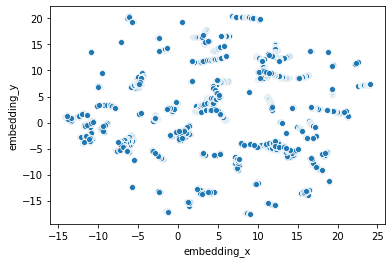

In [38]:
# Reduce dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot Tree-Based Embedding using UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree );

# 5.0 Hyperparameter Fine-Tunning

This step servers for testing how many clusters fits the model the best.

In [39]:
# Save tree base embedding into CSV
df_tree.to_csv(path + 'src\\data\\tree_based_embedding.csv')

# Convert df_tree into X
X = df_tree.copy()

# Check X
X.head()

,embedding_x,embedding_y
0,2.110939,2.280515
1,-11.168382,-2.985210
2,-11.806499,-3.749706
3,11.148773,-4.583150
4,5.252467,-5.936544


# 6.0 Model Training

## 6.1 Final Model

In [40]:
# Final number of clusteres -> 8 
k = 8

# Model definition
model_train = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Model Training
model_train.fit(X)

# Clustering
labels = model_train.labels_

## 6.2 Cluster Validation

In [41]:
# SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.43634262681007385


# 7.0 Cluster Analysis

In [42]:
df9 = X.copy()

# Adding the clustes 
df9['cluster'] = labels

df9.head()

,embedding_x,embedding_y,cluster
0,2.110939,2.280515,3
1,-11.168382,-2.985210,1
2,-11.806499,-3.749706,1
3,11.148773,-4.583150,4
4,5.252467,-5.936544,2


## 7.2 Cluster Profile

In [43]:
df9 =df4[cols_selected].copy() 

# Adding the clustes 
df9['cluster'] = labels

# Change data types
df9['recency_days'] = df9['recency_days'].astype(int)
df9['product_variety'] = df9['product_variety'].astype(int)
df9['returns'] = df9['returns'].astype(int)

df9.head()

,customer_id,gross_revenue,recency_days,product_variety,frequency,returns,cluster
0,17850,5391.21,372,21,0.486111,40,3
1,13047,3232.59,56,105,0.048780,35,1
2,12583,6705.38,2,114,0.045699,50,1
3,13748,948.25,95,24,0.017921,0,4
4,15100,876.00,333,1,0.136364,22,2


In [44]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Average Gross Revenue
df_avg_gross_rev = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_rev, how='inner',on='cluster')

# Average Recency Days
df_avg_rec_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_rec_days, how='inner',on='cluster')


# Average Product Variety
df_avg_pv = df9[['product_variety','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_pv, how='inner',on='cluster')

# Average frequency
df_freq = df9[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_freq, how='inner',on='cluster')

# Average Returns
df_cg = df9[['returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_cg, how='inner',on='cluster')

# Assign cluster Insiders number
insiders = df_cluster.sort_values(by='gross_revenue', ascending=False).cluster.to_list()[0]

# Clusters sorted by gross revenue
df_cluster.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,product_variety,frequency,returns
1,1,622,10.946850,7045.288939,67.276527,208.196141,0.255821,118.389068
5,5,776,13.657163,2458.197706,122.063144,150.672680,0.560110,8.587629
7,7,446,7.849349,2068.398834,91.607623,115.156951,0.380825,11.511211
2,2,687,12.090813,1646.220568,62.493450,39.042213,0.071745,16.248908
4,4,1016,17.881028,765.004872,88.320866,23.921260,0.152151,1.621063
3,3,721,12.689194,753.139778,150.493759,43.177531,0.959256,1.199723
6,6,707,12.442802,262.280651,174.316832,14.172560,0.953059,0.575672
0,0,707,12.442802,240.569675,173.328147,9.237624,0.909091,0.499293


**Cluster Names Ideas:**
* 1 Cluster Insiders
* 5 Cluster More Products
* 7 Cluster Spend Money 
* 2 Cluster Even More Products
* 4 Cluster Less Days
* 3 Cluster Less 1k
* 6 Cluster Stop Returners
* 0 Cluster More Purchases

# 8.0 Deploy

## 8.1 Insert into SQLite

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [45]:
from sqlalchemy import create_engine

# Drop Last Table
query_drop_table = """
    DROP TABLE insiders
"""

conn = sqlite3.connect(path + 'src\\data\\insiders_db.sqlite')
conn.execute(query_drop_table)
conn.commit()

# Create table

query_create_table_insiders = """
    CREATE TABLE insiders (
        customer_id     INTEGER,
        gross_revenue   REAL,
        recency_days    INTERGER,
        product_variety INTERGER,
        frequency       REAL,
        returns         INTEGER,
        cluster         INTEGER
    
    )

"""

conn.execute( query_create_table_insiders )
conn.commit()

# Insert data
conn = create_engine( 'sqlite:///insiders_db.sqlite')
df9.to_sql('insiders', con=conn, if_exists= 'append', index= False) #Index = False


# Select data
query = '''
    SELECT * FROM insiders

'''
df_query = pd.read_sql_query(query, con=conn)

#conn.commit()
conn.close()

# Check database table
print(df_query.shape)
df_query.head()

AttributeError: 'Engine' object has no attribute 'close'